# Chap 05

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import math

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

### 重回帰

In [3]:
df = pd.read_csv('./input/data-attendance-1.txt')
display(df.head())

,A,Score,Y
0,0,69,0.286
1,1,145,0.196
2,0,125,0.261
3,1,86,0.109
4,1,158,0.230


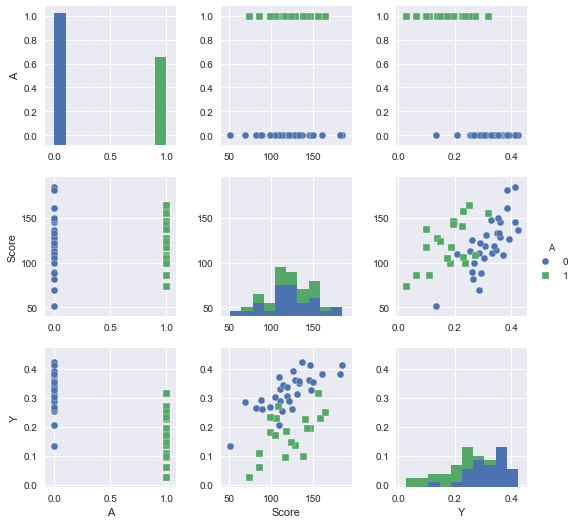

In [175]:
from matplotlib.patches import Ellipse

class Dispatcher(object):

    def __init__(self, fontsize=20, alpha=0.6, cmap='RdBu', threshold=5):
        self.fontsize = fontsize
        self.alpha = alpha
        self.cmap = plt.get_cmap(cmap)

        # 離散値 / 連続値とみなす閾値
        self.threshold = threshold

    def comb(self, x_series, y_series, label=None, color=None):
        """ 下三角部分のプロット """

        x_nunique = x_series.nunique()
        y_nunique = y_series.nunique()

        if x_nunique < self.threshold and y_nunique < self.threshold:
            # 離散値 x 離散値のプロット
            return self._dd_plot(x_series, y_series, label=label)

        elif x_nunique < self.threshold or y_nunique < self.threshold:
            # 離散値 x 連続値のプロット
            return self._dc_plot(x_series, y_series, label=label)

        else:
            # 連続値 x 連続値のプロット
            return plt.scatter(x_series, y_series, label=label)

    def _dd_plot(self, x_series, y_series, label=None):
        """ 離散値 x 離散値のプロット """

        # x, y 各組み合わせの個数を集計
        total = y_series.groupby([x_series, y_series]).count()

        # x, y軸をプロットする位置を取得
        xloc = total.index.labels[0]
        yloc = total.index.labels[1]
        values = total.values

        ax = plt.gca()
        for xp, yp, vp in zip(xloc, yloc, values):
            ax.annotate(vp,
                        (xp, yp),
                        fontsize=self.fontsize,
                        ha='center',
                        va='center')

        # 組み合わせの個数を散布図としてプロット
        size = values / (values.max() * 1.1) * 100 * 20
        ax.scatter(xloc, yloc, s=size, label=label)
        ax.set_ylim(yloc[0] - 0.5, yloc[-1] + 0.5)

    def _dc_plot(self, x_series, y_series, label=None):
        """ 離散値 x 連続値のプロット """

        if y_series.nunique() < x_series.nunique():
            # y軸が離散値の場合は、x, yを入替
            # 水平方向に箱ひげ図をプロット
            orient = "h" 
        else:
            orient = "v" 

        ax = sns.boxplot(x_series, y_series, orient=orient)
        ax = sns.swarmplot(x_series, y_series, orient=orient) 

    def diag(self, x_series, label=None):
        """ 対角部分のプロット """

        x_nunique = x_series.nunique()
        if x_nunique < self.threshold:
            ax = sns.barplot(x_series)
        else:
            ax = sns.distplot(x_series, kde=True, hist_kws=dict(edgecolor="k", linewidth=1))
        ax.yaxis.set_visible(False)

    def ellipse(self, x_series, y_series, label=None, color=None):
        """ 上三角部分のプロット """
        # 相関係数を楕円としてプロット
        r = x_series.corr(y_series)
        c = self.cmap(0.5 * (r + 1))
        ax = plt.gca()
        ax.axis('off')
        artist = Ellipse(xy=[.5, .5],
                         width=np.sqrt(1+r),
                         height=np.sqrt(1-r),
                         angle=45,
                         facecolor=c,
                         edgecolor='none',
                         transform=ax.transAxes)
        ax.add_artist(artist)
        ax.text(.5,
                .5,
                '{:.0f}'.format(r*100),
                fontsize=28,
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes)

       
# d = Dispatcher()

# g = sns.PairGrid(df, diag_sharey=False)
# g.map_diag(plt.hist)
# g.map_lower(d.comb)
# g.map_upper(d.ellipse)

sns.pairplot(df, hue='A', markers=["o", "s"])

In [176]:
model = pystan.StanModel(file='./model/model5-3.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bc757e35b5293ba1890ed1ca17a86368 NOW.


In [178]:
stan_data = {
    'A': df['A'].values,
    'Score': df['Score'].values / 200,
    'Y': df['Y'].values,
    'N': df.shape[0]
}
fit = model.sampling(data=stan_data, seed=1234)

In [179]:
fit

Inference for Stan model: anon_model_bc757e35b5293ba1890ed1ca17a86368.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1           0.12  8.5e-4   0.03   0.06    0.1   0.12   0.15   0.19   1538    1.0
b2          -0.14  3.0e-4   0.01  -0.17  -0.15  -0.14  -0.13  -0.11   2485    1.0
b3           0.32  1.3e-3   0.05   0.22   0.29   0.33   0.36   0.43   1544    1.0
sigma        0.05  1.2e-4 5.5e-3   0.04   0.05   0.05   0.06   0.06   2065    1.0
mu[0]        0.24  4.0e-4   0.02    0.2   0.22   0.24   0.25   0.27   1778    1.0
mu[1]        0.21  2.8e-4   0.01   0.19   0.21   0.22   0.22   0.24   2212    1.0
mu[2]        0.33  1.7e-4 9.7e-3   0.31   0.32   0.33   0.33   0.35   3264    1.0
mu[3]        0.12  3.2e-4   0.01   0.09   0.11   0.12   0.13   0.15   2109    1.0
mu[4]        0.24  3.4e-4   0.02   0.21   0.23   0.24   0.25   0.27   196

/Users/tomohiro/Workspace/RStanBook-Python/.env/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  This is separate from the ipykernel package so we can avoid doing imports until


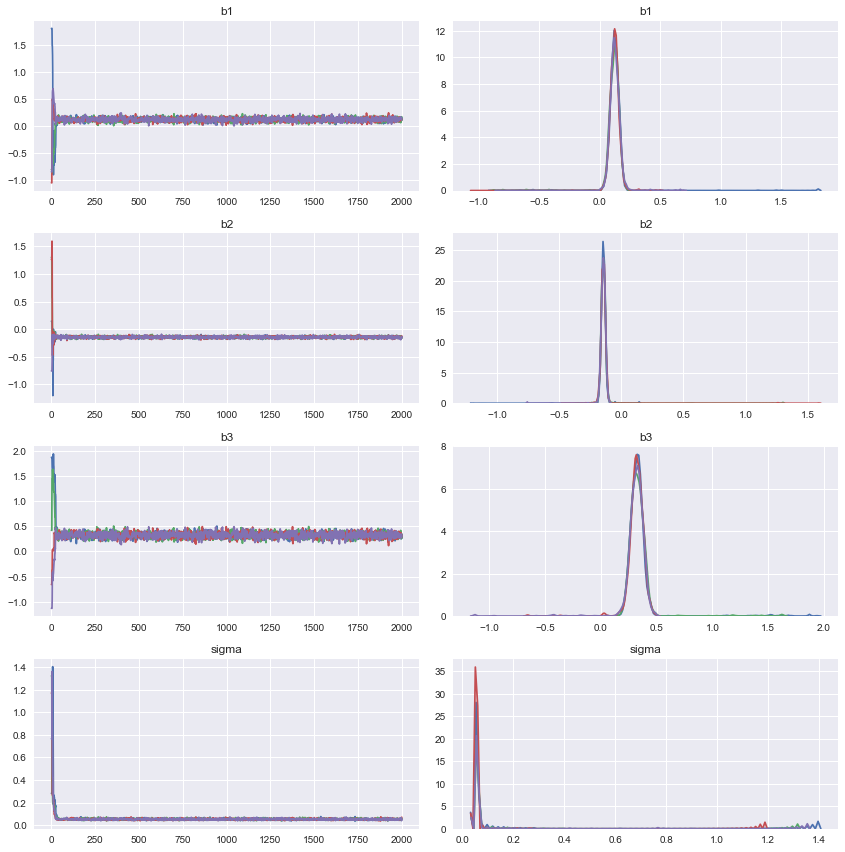

In [180]:
def mcmc_plot(fit):
    palette = sns.color_palette()
    ms = fit.extract(permuted=False, inc_warmup=True)
    iter_from = fit.sim['warmup']
    iter_range = np.arange(0, ms.shape[0])
    paraname = fit.sim['fnames_oi']

    plt.figure(figsize=(12, 12))
    for pos in range(4):
        pi = pos
        if pi >= len(paraname): break
        plt.subplot(4, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.subplot(4, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])

mcmc_plot(fit)

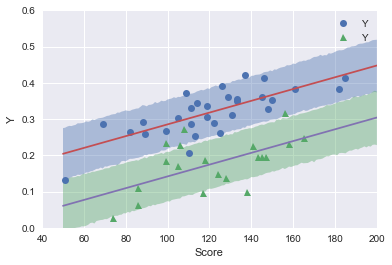

In [317]:
Score = np.arange(50, 201)
b1 = fit.extract()['b1']
b2 = fit.extract()['b2']
b3 = fit.extract()['b3']
sigma = fit.extract()['sigma']
mu_0 = np.zeros((len(Score), b1.shape[0]))
mu_1 = np.zeros((len(Score), b1.shape[0]))
for i, s in enumerate(Score):
    mu_0[i] = b1 + b2 * 0 + b3 * s / 200.0
    mu_1[i] = b1 + b2 * 1 + b3 * s / 200.0

y_0 = np.random.normal(loc=mu_0, scale=sigma)
y_1 = np.random.normal(loc=mu_1, scale=sigma)

plt.plot(df[df['A'] == 0]['Score'], df[df['A'] == 0]['Y'], 'o')
plt.plot(df[df['A'] == 1]['Score'], df[df['A'] == 1]['Y'], '^')
plt.plot(Score, mu_0.mean(axis=1))
plt.plot(Score, mu_1.mean(axis=1))

plt.fill_between(Score, np.percentile(y_0, 10.0, axis=1), np.percentile(y_0, 90.0, axis=1), alpha=0.4)
plt.fill_between(Score, np.percentile(y_1, 10.0, axis=1), np.percentile(y_1, 90.0, axis=1), alpha=0.4)
plt.xlim(40, 200)
plt.ylim(0.0, 0.6)
plt.xlabel('Score')
plt.ylabel('Y')
plt.legend()

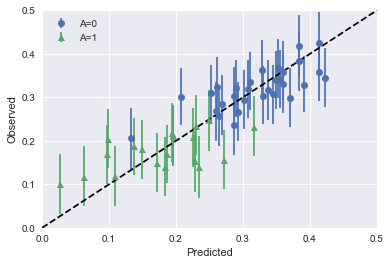

In [350]:
y_pred = fit.extract()['y_pred'].T
A = df['A'].values

y_pred_err_u = np.median(y_pred, axis=1) - np.percentile(y_pred, 10.0, axis=1)
y_pred_err_d = np.percentile(y_pred, 90.0, axis=1) - np.median(y_pred, axis=1)
y_pred_err = np.vstack([y_pred_err_u, y_pred_err_d])

plt.errorbar(df[df['A'] == 0]['Y'], np.median(y_pred[A == 0], axis=1), yerr=y_pred_err[:, A == 0], fmt="o", label="A=0")
plt.errorbar(df[df['A'] == 1]['Y'], np.median(y_pred[A == 1], axis=1), yerr=y_pred_err[:, A == 1], fmt='^', label="A=1")
plt.plot([0, 0.5], [0, 0.5], "k--")
plt.xlim(0.0, 0.5)
plt.ylim(0.0, 0.5)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.legend()

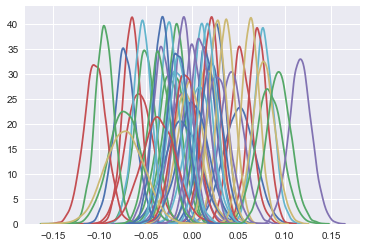

In [530]:
epc = (df['Y'].values - fit.extract()['mu']).T
for i in range(epc.shape[0]):
    sns.distplot(epc[i], hist=False)

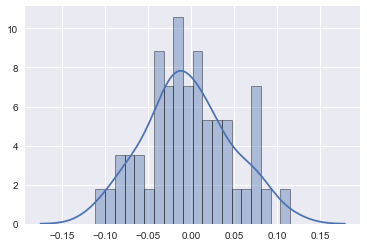

In [549]:
epc_map = []
for i in range(epc.shape[0]):
    epc_hist = np.histogram(epc[i])
    epc_map.append(epc_hist[1][np.argmax(epc_hist[0])])
sns.distplot(epc_map, bins=20, hist_kws=dict(edgecolor="k", linewidth=1))

/Users/tomohiro/Workspace/RStanBook-Python/.env/lib/python3.5/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)


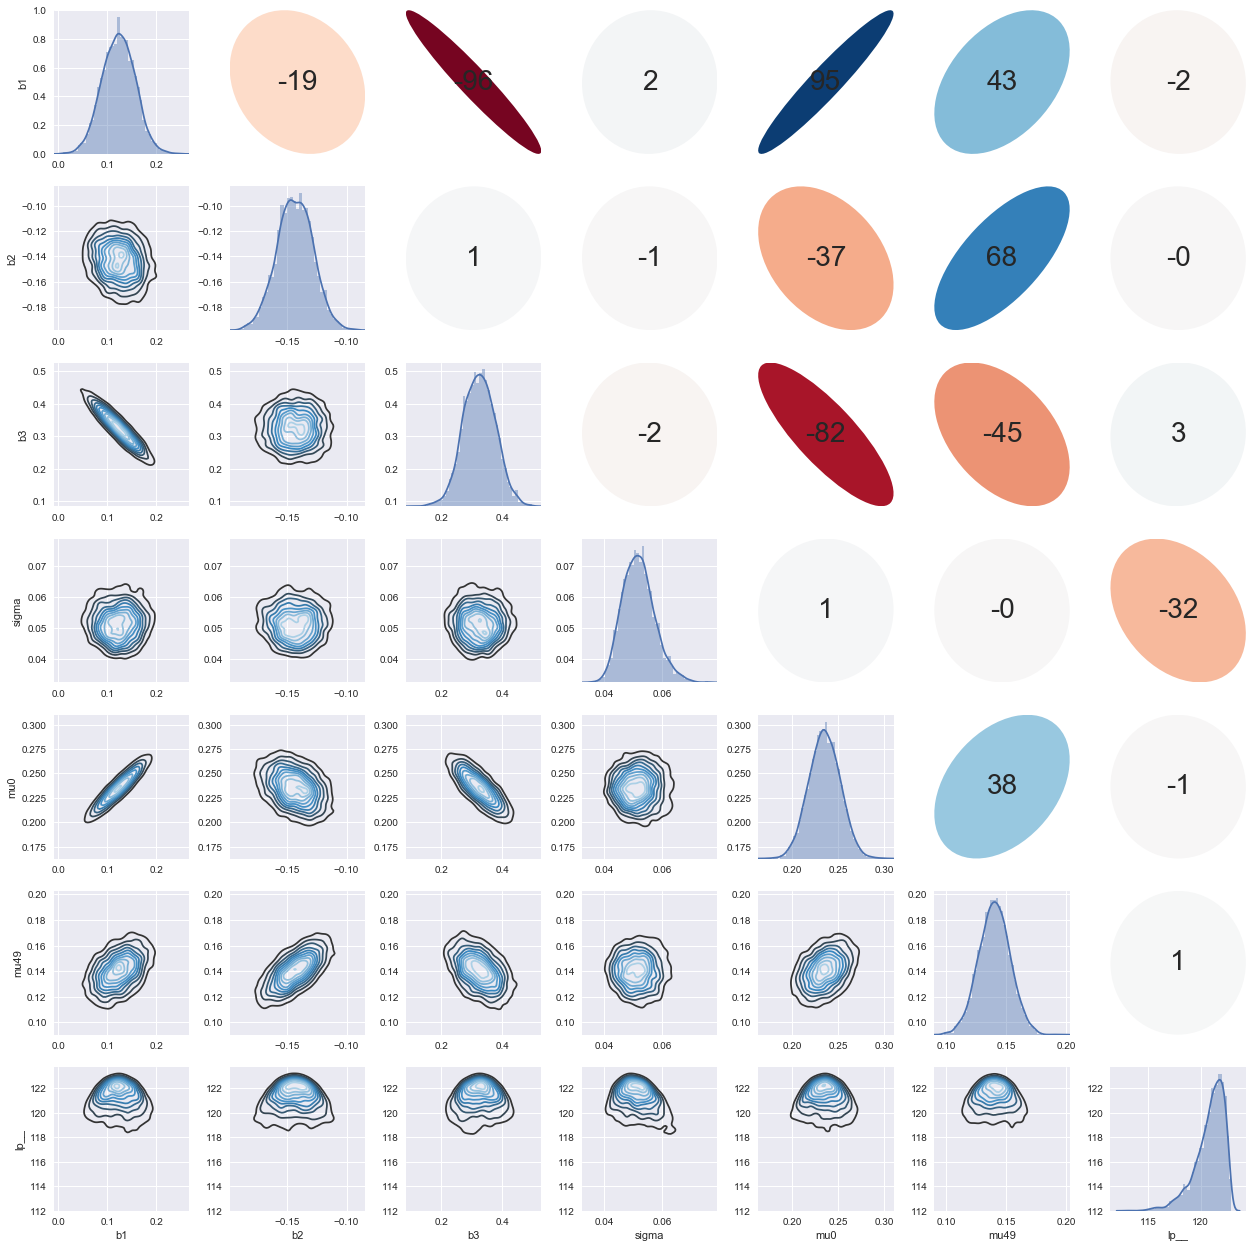

In [592]:
df = pd.DataFrame({
    'b1': fit.extract()['b1'],
    'b2': fit.extract()['b2'],
    'b3': fit.extract()['b3'],
    'sigma': fit.extract()['sigma'],
    'mu0': fit.extract()['mu'][:, 0],
    'mu49': fit.extract()['mu'][:, 49],
    'lp__': fit.extract()['lp__'],
}, columns=['b1', 'b2', 'b3', 'sigma', 'mu1', 'mu50', 'lp__'])
df = df[['b1', 'b2', 'b3', 'sigma', 'mu0', 'mu49', 'lp__']]
g = sns.PairGrid(df, diag_sharey=False)
g.map_diag(sns.distplot)
g.map_lower(sns.kdeplot, cmap='Blues_d')
g.map_upper(d.ellipse)

### 二項ロジスティック回帰

In [606]:
df = pd.read_csv('./input/data-attendance-2.txt')
df = df.drop(['PersonID'], axis=1)
df['ratio'] = df['Y'] / df['M']
print(df.shape)
df.head()

(50, 5)


,A,Score,M,Y,ratio
0,0,69,43,38,0.883721
1,1,145,56,40,0.714286
2,0,125,32,24,0.750000
3,1,86,45,33,0.733333
4,1,158,33,23,0.696970


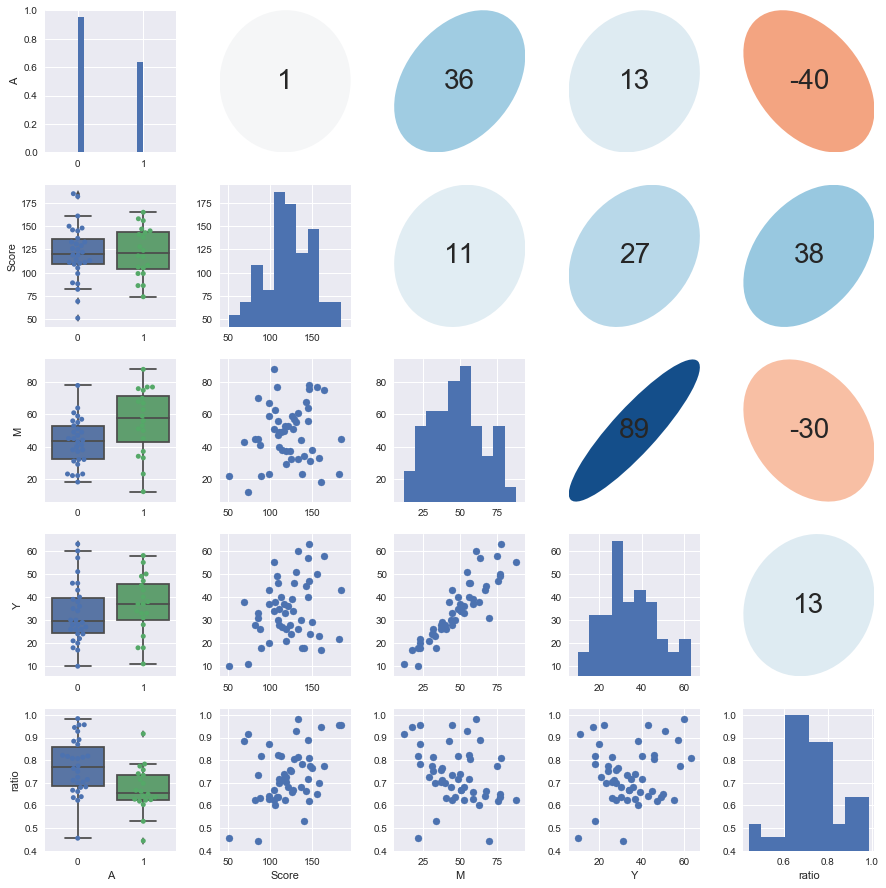

In [607]:
d = Dispatcher()

g = sns.PairGrid(df, diag_sharey=False)
g.map_diag(plt.hist)
g.map_lower(d.comb)
g.map_upper(d.ellipse)

In [608]:
model = pystan.StanModel('./model/model5-4.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_004c106b40e5e7fb5b70c573034b1234 NOW.


Inference for Stan model: anon_model_004c106b40e5e7fb5b70c573034b1234.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1           0.08  5.9e-3   0.22  -0.36  -0.08   0.07   0.23   0.52   1468    1.0
b2          -0.62  2.3e-3   0.09   -0.8  -0.68  -0.62  -0.56  -0.45   1554    1.0
b3           1.93  9.8e-3   0.36   1.22   1.69   1.93   2.17   2.64   1376    1.0
q[0]         0.68  5.9e-4   0.02   0.63   0.66   0.68   0.69   0.72   1664    1.0
q[1]          0.7  3.6e-4   0.02   0.67   0.69    0.7   0.71   0.73   1957    1.0
q[2]         0.78  2.5e-4   0.01   0.76   0.77   0.78   0.79   0.81   2103    1.0
q[3]         0.57  5.2e-4   0.02   0.53   0.56   0.57   0.59   0.61   1736    1.0
q[4]         0.73  4.4e-4   0.02   0.69   0.72   0.73   0.74   0.76   1726    1.0
q[5]          0.8  2.8e-4   0.01   0.77   0.79    0.8    0.8   0.82   183

/Users/tomohiro/Workspace/RStanBook-Python/.env/lib/python3.5/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  del sys.path[0]


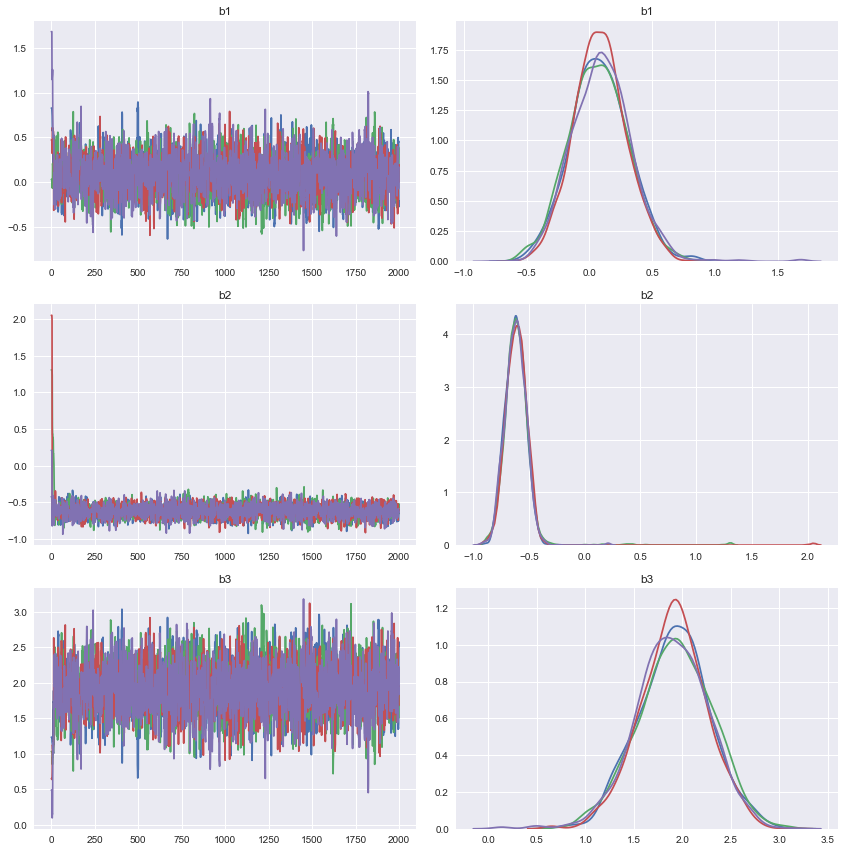

In [611]:
stan_data = {
    'A': df['A'].values,
    'Score': df['Score'].values / 200,
    'Y': df['Y'].values,
    'M': df['M'].values,
    'N': df.shape[0]
}
fit = model.sampling(data=stan_data, seed=1234)
display(fit)

def mcmc_plot(fit):
    palette = sns.color_palette()
    ms = fit.extract(permuted=False, inc_warmup=True)
    iter_from = fit.sim['warmup']
    iter_range = np.arange(0, ms.shape[0])
    paraname = fit.sim['fnames_oi']

    plt.figure(figsize=(12, 12))
    for pos in range(3):
        pi = pos
        if pi >= len(paraname): break
        plt.subplot(3, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.subplot(3, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])

mcmc_plot(fit)

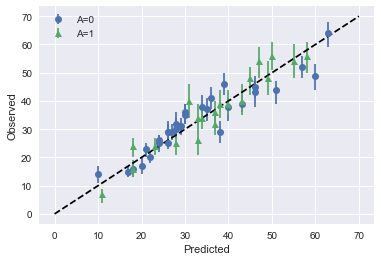

In [614]:
y_pred = fit.extract()['y_pred'].T
A = df['A'].values

y_pred_err_u = np.median(y_pred, axis=1) - np.percentile(y_pred, 10.0, axis=1)
y_pred_err_d = np.percentile(y_pred, 90.0, axis=1) - np.median(y_pred, axis=1)
y_pred_err = np.vstack([y_pred_err_u, y_pred_err_d])

plt.errorbar(df[df['A'] == 0]['Y'], np.median(y_pred[A == 0], axis=1), yerr=y_pred_err[:, A == 0], fmt="o", label="A=0")
plt.errorbar(df[df['A'] == 1]['Y'], np.median(y_pred[A == 1], axis=1), yerr=y_pred_err[:, A == 1], fmt='^', label="A=1")
plt.plot([0, 70], [0, 70], "k--")
# plt.xlim(0.0, 0.5)
# plt.ylim(0.0, 0.5)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.legend()

### ロジスティック回帰

In [112]:
df = pd.read_csv('./input/data-attendance-3.txt').drop('PersonID', axis=1)
print(df.shape)
df.head()

(2396, 4)


,A,Score,Weather,Y
0,0,69,B,1
1,0,69,A,1
2,0,69,C,1
3,0,69,A,1
4,0,69,B,1


In [97]:
pd.get_dummies(df, columns='Y').groupby('Weather')[['Y_0', 'Y_1']].sum()

,Y_0,Y_1
Weather,,
A,306.0,953.0
B,230.0,500.0
C,138.0,269.0


In [117]:
w_map = dict(A=0.0, B=0.2, C=0)
df['W'] = df['Weather'].apply(lambda x: w_map[x])
df.head()

,A,Score,Weather,Y,W
0,0,69,B,1,0.2
1,0,69,A,1,0.0
2,0,69,C,1,0.0
3,0,69,A,1,0.0
4,0,69,B,1,0.2


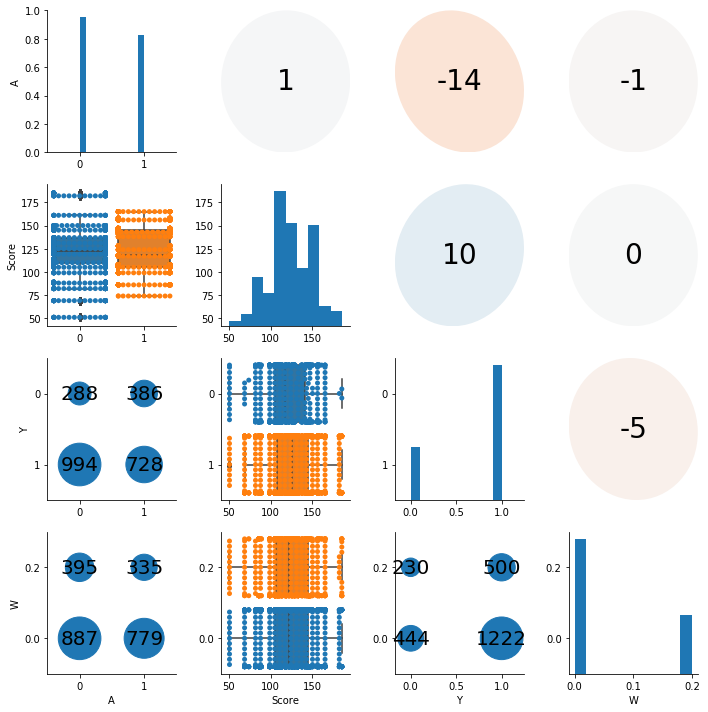

In [101]:
from matplotlib.patches import Ellipse

class Dispatcher(object):

    def __init__(self, fontsize=20, alpha=0.6, cmap='RdBu', threshold=5):
        self.fontsize = fontsize
        self.alpha = alpha
        self.cmap = plt.get_cmap(cmap)

        # 離散値 / 連続値とみなす閾値
        self.threshold = threshold

    def comb(self, x_series, y_series, label=None, color=None):
        """ 下三角部分のプロット """

        x_nunique = x_series.nunique()
        y_nunique = y_series.nunique()

        if x_nunique < self.threshold and y_nunique < self.threshold:
            # 離散値 x 離散値のプロット
            return self._dd_plot(x_series, y_series, label=label)

        elif x_nunique < self.threshold or y_nunique < self.threshold:
            # 離散値 x 連続値のプロット
            return self._dc_plot(x_series, y_series, label=label)

        else:
            # 連続値 x 連続値のプロット
            return plt.scatter(x_series, y_series, label=label)

    def _dd_plot(self, x_series, y_series, label=None):
        """ 離散値 x 離散値のプロット """

        # x, y 各組み合わせの個数を集計
        total = y_series.groupby([x_series, y_series]).count()

        # x, y軸をプロットする位置を取得
        xloc = total.index.labels[0]
        yloc = total.index.labels[1]
        values = total.values

        ax = plt.gca()
        for xp, yp, vp in zip(xloc, yloc, values):
            ax.annotate(vp,
                        (xp, yp),
                        fontsize=self.fontsize,
                        ha='center',
                        va='center')

        # 組み合わせの個数を散布図としてプロット
        size = values / (values.max() * 1.1) * 100 * 20
        ax.scatter(xloc, yloc, s=size, label=label)
        ax.set_ylim(yloc[0] - 0.5, yloc[-1] + 0.5)

    def _dc_plot(self, x_series, y_series, label=None):
        """ 離散値 x 連続値のプロット """

        if y_series.nunique() < x_series.nunique():
            # y軸が離散値の場合は、x, yを入替
            # 水平方向に箱ひげ図をプロット
            orient = "h" 
        else:
            orient = "v" 

        ax = sns.boxplot(x_series, y_series, orient=orient)
        ax = sns.swarmplot(x_series, y_series, orient=orient) 

    def diag(self, x_series, label=None):
        """ 対角部分のプロット """

        x_nunique = x_series.nunique()
        if x_nunique < self.threshold:
            ax = sns.barplot(x_series)
        else:
            ax = sns.distplot(x_series, kde=True, hist_kws=dict(edgecolor="k", linewidth=1))
        ax.yaxis.set_visible(False)

    def ellipse(self, x_series, y_series, label=None, color=None):
        """ 上三角部分のプロット """
        # 相関係数を楕円としてプロット
        r = x_series.corr(y_series)
        c = self.cmap(0.5 * (r + 1))
        ax = plt.gca()
        ax.axis('off')
        artist = Ellipse(xy=[.5, .5],
                         width=np.sqrt(1+r),
                         height=np.sqrt(1-r),
                         angle=45,
                         facecolor=c,
                         edgecolor='none',
                         transform=ax.transAxes)
        ax.add_artist(artist)
        ax.text(.5,
                .5,
                '{:.0f}'.format(r*100),
                fontsize=28,
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes)

d = Dispatcher()

g = sns.PairGrid(df.drop('Weather', axis=1), diag_sharey=False)
g.map_diag(plt.hist)
g.map_lower(d.comb)
g.map_upper(d.ellipse)

In [102]:
model = pystan.StanModel('model/model5-5.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_48e61760c06954eaca7731733e2c6479 NOW.


In [103]:
stan_data = {
    'A': df['A'].values,
    'Score': df['Score'].values / 200,
    'W': df['W'].values,
    'Y': df['Y'].values,
    'I': df.shape[0]
}
fit = model.sampling(data=stan_data, seed=1234)
display(fit)

Inference for Stan model: anon_model_48e61760c06954eaca7731733e2c6479.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]      0.17  5.5e-3   0.23  -0.28   0.02   0.17   0.33   0.62   1780    1.0
b[1]     -0.62  1.8e-3   0.09  -0.81  -0.69  -0.62  -0.56  -0.44   2821    1.0
b[2]      1.91  8.5e-3   0.37   1.17   1.66    1.9   2.16   2.64   1887    1.0
b[3]     -1.24  9.2e-3    0.5  -2.22  -1.58  -1.23  -0.92  -0.29   2915    1.0
q[0]      0.64  6.4e-4   0.03   0.58   0.62   0.64   0.66    0.7   2328    1.0
q[1]       0.7  5.6e-4   0.02   0.65   0.68    0.7   0.71   0.74   1945    1.0
q[2]       0.7  5.6e-4   0.02   0.65   0.68    0.7   0.71   0.74   1945    1.0
q[3]       0.7  5.6e-4   0.02   0.65   0.68    0.7   0.71   0.74   1945    1.0
q[4]      0.64  6.4e-4   0.03   0.58   0.62   0.64   0.66    0.7   2328    1.0
q[5]      0.64  6.4e-

/Users/tomohiro/Workspace/RStanBook-Python/.env/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  This is separate from the ipykernel package so we can avoid doing imports until


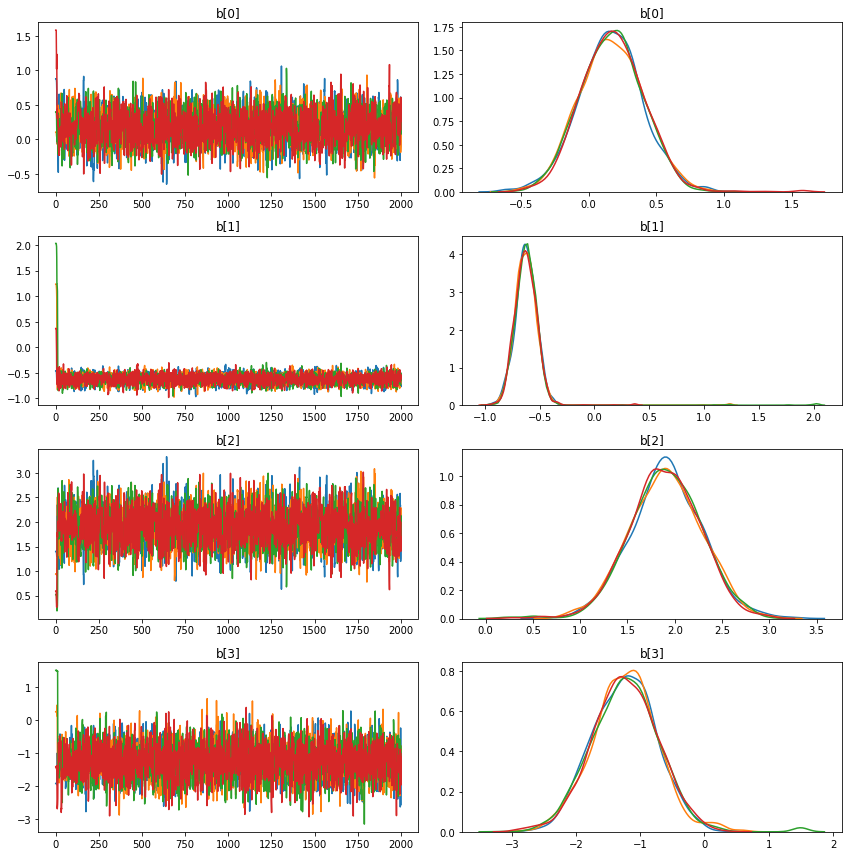

In [104]:
def mcmc_plot(fit):
    palette = sns.color_palette()
    ms = fit.extract(permuted=False, inc_warmup=True)
    iter_from = fit.sim['warmup']
    iter_range = np.arange(0, ms.shape[0])
    paraname = fit.sim['fnames_oi']

    plt.figure(figsize=(12, 12))
    for pos in range(4):
        pi = pos
        if pi >= len(paraname): break
        plt.subplot(4, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.subplot(4, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])

mcmc_plot(fit)

In [105]:
df_q = pd.DataFrame()
q = fit.extract()['q'].T
df_q['q_lower'] = np.percentile(q, 10.0, axis=1)
df_q['q_upper'] = np.percentile(q, 90.0, axis=1)
df_q['q_med'] = np.median(q, axis=1)
print(df_q.shape)
df_q.head()
df_concat = pd.concat([df, df_q], axis=1)
df_concat.head()

(2396, 3)


,A,Score,Weather,Y,W,q_lower,q_upper,q_med
0,0,69,B,1,0.2,0.601233,0.680990,0.640201
1,0,69,A,1,0.0,0.663547,0.726887,0.695766
2,0,69,C,1,0.0,0.663547,0.726887,0.695766
3,0,69,A,1,0.0,0.663547,0.726887,0.695766
4,0,69,B,1,0.2,0.601233,0.680990,0.640201


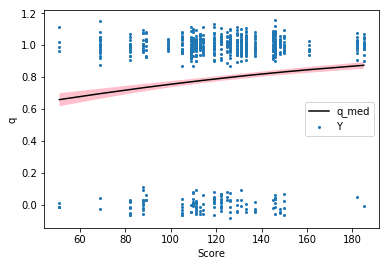

In [106]:
df_filtered = df_concat.query("A == 0 & Weather == 'A'")
df_filtered = df_filtered.sort_values("Score")

y_randomized = [y + np.random.normal(0, 0.05) for y in df_filtered["Y"]]

fig, ax = plt.subplots()
ax.plot(df_filtered["Score"], df_filtered["q_med"], "k-")
ax.fill_between(df_filtered["Score"], df_filtered["q_lower"], df_filtered["q_upper"], facecolor="pink")
ax.plot(df_filtered["Score"], y_randomized, "o", markersize=2, label="Y")
ax.legend()
ax.set_xlabel("Score")
ax.set_ylabel("q")
plt.show()

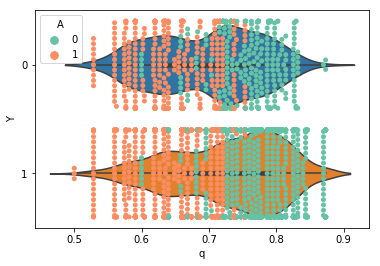

In [107]:
fig, ax = plt.subplots()
sns.violinplot(data=df_concat, x="q_med", y="Y", ax=ax, orient="h")
sns.swarmplot(data=df_concat, x="q_med", y="Y", hue="A", ax=ax, orient="h", palette=sns.color_palette("Set2", n_colors=2))
ax.set_xlabel("q")
ax.set_ylabel("Y")
plt.show()

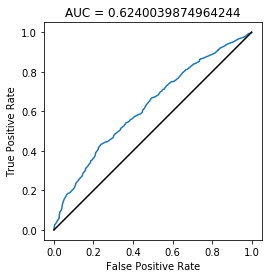

In [108]:
from sklearn.metrics import roc_curve, roc_auc_score

Y = df['Y'].values
auc = roc_auc_score(Y, q_med)

false_positive_rate, true_positive_rate, _ = roc_curve(Y, q_med)
fig, ax = plt.subplots()
ax.plot(false_positive_rate, true_positive_rate)
ax.plot([0, 1], [0, 1], "k-")

ax.set_aspect('equal')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("AUC = {0}".format(auc))
plt.show()

#### exercise

In [118]:
pd.get_dummies(df, columns='Y').groupby('A')[['Y_0', 'Y_1']].sum()

,Y_0,Y_1
A,,
0,288.0,994.0
1,386.0,728.0


In [119]:
df = pd.get_dummies(df, columns=['Weather'], drop_first=True).drop('W', axis=1)
df.head()

,A,Score,Y,Weather_B,Weather_C
0,0,69,1,1,0
1,0,69,1,0,0
2,0,69,1,0,1
3,0,69,1,0,0
4,0,69,1,1,0


In [128]:
model = pystan.StanModel('./exercise/ex4.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_03931b2c7b449c6b4d3ec3d28883ac76 NOW.


In [129]:
stan_data = {
    'A': df['A'].values,
    'Score': df['Score'].values / 200,
    'WB': df['Weather_B'].values,
    'WC': df['Weather_C'].values,
    'Y': df['Y'].values,
    'I': df.shape[0]
}
fit = model.sampling(data=stan_data, seed=1234)
display(fit)

Inference for Stan model: anon_model_03931b2c7b449c6b4d3ec3d28883ac76.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]      0.27  5.0e-3   0.23  -0.19   0.11   0.27   0.42   0.72   2152    1.0
b[1]     -0.63  1.6e-3    0.1  -0.81  -0.69  -0.63  -0.56  -0.44   3512    1.0
b[2]      1.96  7.8e-3   0.37   1.25   1.71   1.96   2.21   2.69   2224    1.0
b[3]     -0.38  1.8e-3    0.1  -0.58  -0.45  -0.38  -0.31  -0.19   3133    1.0
b[4]     -0.49  2.3e-3   0.13  -0.74  -0.58  -0.49  -0.41  -0.24   2926    1.0
q[0]      0.64  5.9e-4   0.03   0.58   0.62   0.64   0.66   0.69   2593    1.0
q[1]      0.72  5.2e-4   0.02   0.67    0.7   0.72   0.74   0.77   2315    1.0
q[2]      0.61  6.8e-4   0.04   0.54   0.59   0.61   0.64   0.68   2769    1.0
q[3]      0.72  5.2e-4   0.02   0.67    0.7   0.72   0.74   0.77   2315    1.0
q[4]      0.64  5.9e-

/Users/tomohiro/Workspace/RStanBook-Python/.env/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  This is separate from the ipykernel package so we can avoid doing imports until


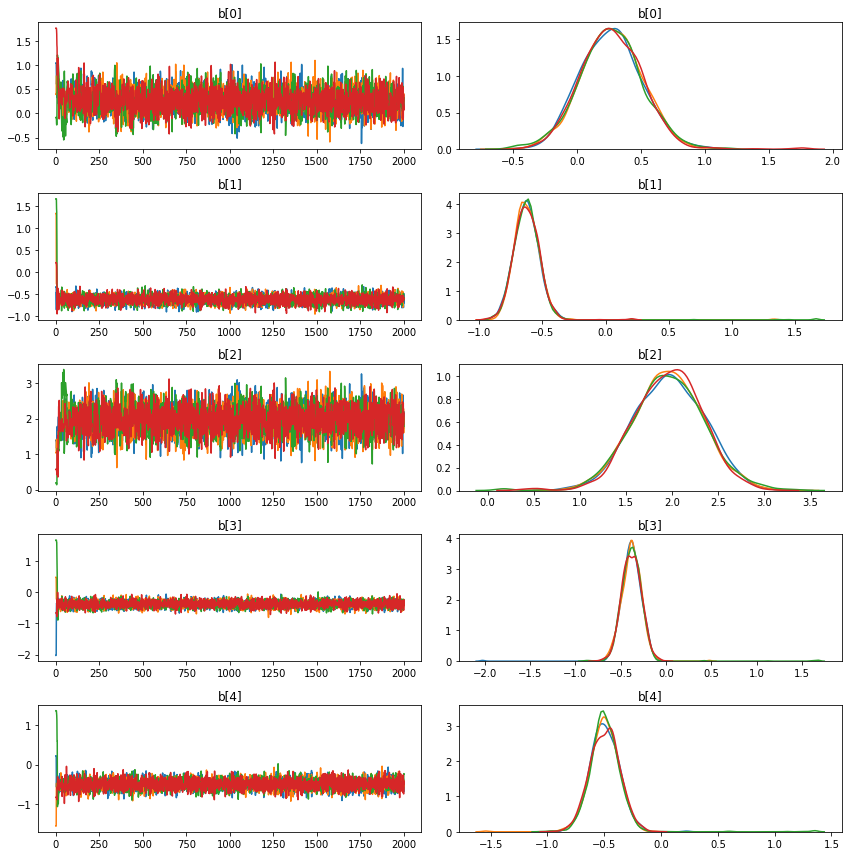

In [130]:
def mcmc_plot(fit):
    palette = sns.color_palette()
    ms = fit.extract(permuted=False, inc_warmup=True)
    iter_from = fit.sim['warmup']
    iter_range = np.arange(0, ms.shape[0])
    paraname = fit.sim['fnames_oi']

    plt.figure(figsize=(12, 12))
    for pos in range(5):
        pi = pos
        if pi >= len(paraname): break
        plt.subplot(5, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.subplot(5, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])

mcmc_plot(fit)

In [131]:
df_q = pd.DataFrame()
q = fit.extract()['q'].T
df_q['q_lower'] = np.percentile(q, 10.0, axis=1)
df_q['q_upper'] = np.percentile(q, 90.0, axis=1)
df_q['q_med'] = np.median(q, axis=1)
print(df_q.shape)
df_q.head()
df_concat = pd.concat([df, df_q], axis=1)
df_concat.head()

(2396, 3)


,A,Score,Y,Weather_B,Weather_C,q_lower,q_upper,q_med
0,0,69,1,1,0,0.598221,0.675841,0.638268
1,0,69,1,0,0,0.687134,0.750930,0.720195
2,0,69,1,0,1,0.564471,0.656402,0.611476
3,0,69,1,0,0,0.687134,0.750930,0.720195
4,0,69,1,1,0,0.598221,0.675841,0.638268


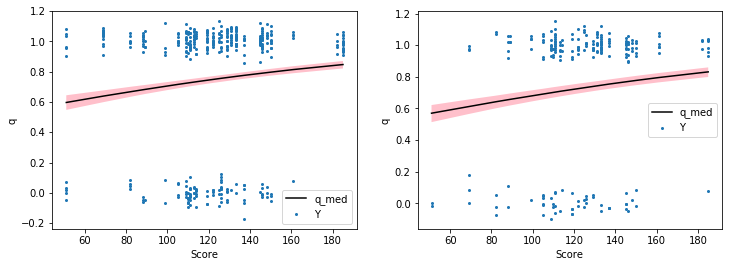

In [143]:
df_filtered = df_concat.query("A == 0 & Weather_B == '1'")
df_filtered = df_filtered.sort_values("Score")

y_randomized = [y + np.random.normal(0, 0.05) for y in df_filtered["Y"]]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(df_filtered["Score"], df_filtered["q_med"], "k-")
ax[0].fill_between(df_filtered["Score"], df_filtered["q_lower"], df_filtered["q_upper"], facecolor="pink")
ax[0].plot(df_filtered["Score"], y_randomized, "o", markersize=2, label="Y")
ax[0].legend()
ax[0].set_xlabel("Score")
ax[0].set_ylabel("q")

df_filtered = df_concat.query("A == 0 & Weather_C == '1'")
df_filtered = df_filtered.sort_values("Score")

y_randomized = [y + np.random.normal(0, 0.05) for y in df_filtered["Y"]]

ax[1].plot(df_filtered["Score"], df_filtered["q_med"], "k-")
ax[1].fill_between(df_filtered["Score"], df_filtered["q_lower"], df_filtered["q_upper"], facecolor="pink")
ax[1].plot(df_filtered["Score"], y_randomized, "o", markersize=2, label="Y")
ax[1].legend()
ax[1].set_xlabel("Score")
ax[1].set_ylabel("q")

plt.show()

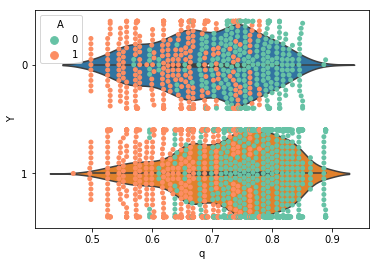

In [144]:
fig, ax = plt.subplots()
sns.violinplot(data=df_concat, x="q_med", y="Y", ax=ax, orient="h")
sns.swarmplot(data=df_concat, x="q_med", y="Y", hue="A", ax=ax, orient="h", palette=sns.color_palette("Set2", n_colors=2))
ax.set_xlabel("q")
ax.set_ylabel("Y")
plt.show()

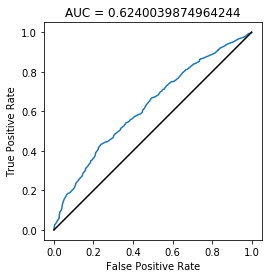

In [145]:
from sklearn.metrics import roc_curve, roc_auc_score

Y = df['Y'].values
auc = roc_auc_score(Y, q_med)

false_positive_rate, true_positive_rate, _ = roc_curve(Y, q_med)
fig, ax = plt.subplots()
ax.plot(false_positive_rate, true_positive_rate)
ax.plot([0, 1], [0, 1], "k-")

ax.set_aspect('equal')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("AUC = {0}".format(auc))
plt.show()

### ポアソン回帰

In [163]:
df = pd.read_csv('./input/data-attendance-2.txt').drop(['PersonID', 'Y'], axis=1)
df.head()

,A,Score,M
0,0,69,43
1,1,145,56
2,0,125,32
3,1,86,45
4,1,158,33


In [164]:
model = pystan.StanModel('./model/model5-6b.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3dc71601d7a02cbcf484ed92cd1a0836 NOW.


In [165]:
stan_data = {
    'A': df['A'].values,
    'Score': df['Score'].values / 200,
    'M': df['M'].values,
    'N': df.shape[0],
}
fit = model.sampling(data=stan_data, seed=1234)
display(fit)

Inference for Stan model: anon_model_3dc71601d7a02cbcf484ed92cd1a0836.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]         3.58  2.5e-3   0.09   3.39   3.52   3.58   3.64   3.76   1336    1.0
b[1]         0.26  9.9e-4   0.04   0.18   0.24   0.26   0.29   0.35   1818    1.0
b[2]         0.29  4.0e-3   0.15-3.1e-3   0.19   0.29   0.38   0.58   1357    1.0
lambda[0]    3.68  1.2e-3   0.05   3.58   3.65   3.68   3.71   3.77   1446    1.0
lambda[1]    4.05  7.1e-4   0.03   3.98   4.03   4.05   4.07   4.12   2324    1.0
lambda[2]    3.76  5.7e-4   0.03   3.71   3.74   3.76   3.78   3.81   2387    1.0
lambda[3]    3.97  9.8e-4   0.04   3.89   3.94   3.97   3.99   4.04   1739    1.0
lambda[4]    4.07  8.7e-4   0.04   3.99   4.05   4.07    4.1   4.15   2022    1.0
lambda[5]    3.77  6.0e-4   0.03   3.71   3.75   3.77   3.79   3.83   237

/Users/tomohiro/Workspace/RStanBook-Python/.env/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  This is separate from the ipykernel package so we can avoid doing imports until


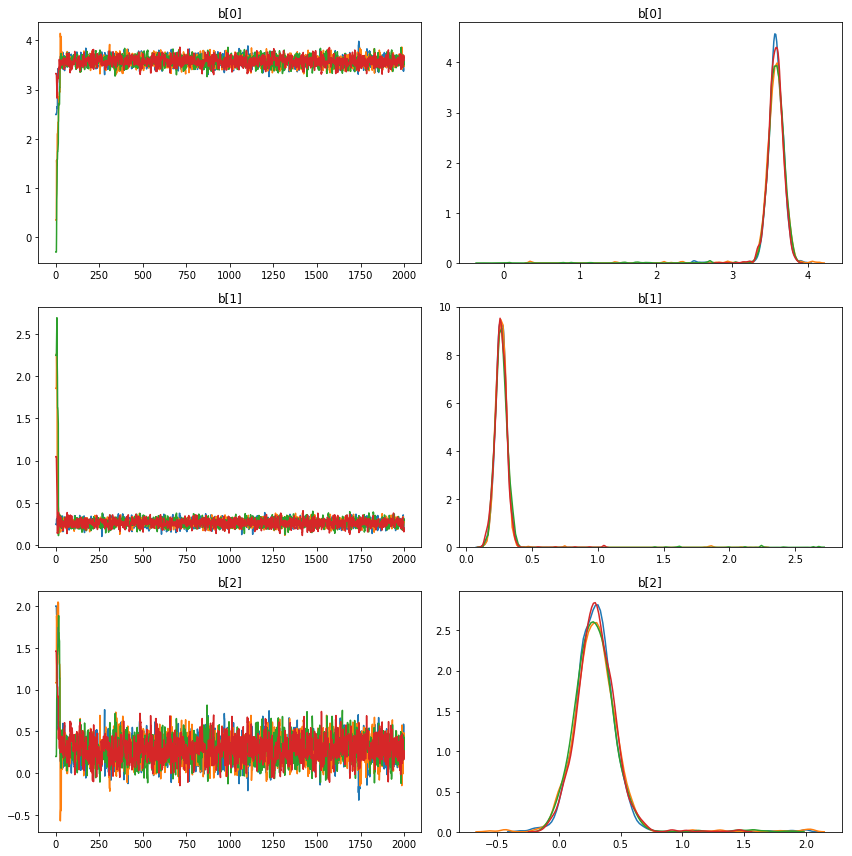

In [167]:
def mcmc_plot(fit, n_params):
    palette = sns.color_palette()
    ms = fit.extract(permuted=False, inc_warmup=True)
    iter_from = fit.sim['warmup']
    iter_range = np.arange(0, ms.shape[0])
    paraname = fit.sim['fnames_oi']

    plt.figure(figsize=(12, 12))
    for pos in range(n_params):
        pi = pos
        if pi >= len(paraname): break
        plt.subplot(n_params, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.subplot(n_params, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])

mcmc_plot(fit, 3)

#### exercise

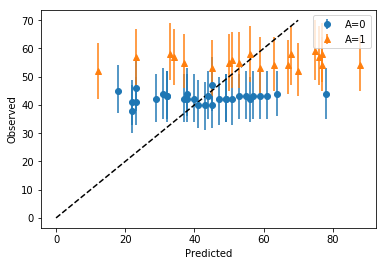

In [168]:
m_pred = fit.extract()['m_pred'].T
A = df['A'].values

m_pred_err_u = np.median(m_pred, axis=1) - np.percentile(m_pred, 10.0, axis=1)
m_pred_err_d = np.percentile(m_pred, 90.0, axis=1) - np.median(m_pred, axis=1)
m_pred_err = np.vstack([m_pred_err_u, m_pred_err_d])

plt.errorbar(df[df['A'] == 0]['M'], np.median(m_pred[A == 0], axis=1), yerr=m_pred_err[:, A == 0], fmt="o", label="A=0")
plt.errorbar(df[df['A'] == 1]['M'], np.median(m_pred[A == 1], axis=1), yerr=m_pred_err[:, A == 1], fmt='^', label="A=1")
plt.plot([0, 70], [0, 70], "k--")
# plt.xlim(0.0, 0.5)
# plt.ylim(0.0, 0.5)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.legend()

In [207]:
df = pd.read_csv('./input/data3a.csv')
df.head()

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C


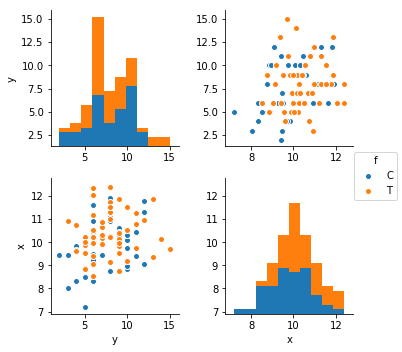

In [208]:
sns.pairplot(df, hue='f')

In [209]:
f_map = dict(C=0, T=1)
df['f'] = df['f'].apply(lambda x: f_map[x])
df.head()

,y,x,f
0,6,8.31,0
1,6,9.44,0
2,6,9.50,0
3,12,9.07,0
4,10,10.16,0


In [210]:
model = pystan.StanModel('./exercise/ex6.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_07af9f9a0af78c7a0d2936c24d4d49a0 NOW.


In [211]:
stan_data = {
    'F': df['f'].values,
    'X': df['x'].values,
    'Y': df['y'].values,
    'N': df.shape[0],
}
fit = model.sampling(data=stan_data, seed=1234)
display(fit)

Inference for Stan model: anon_model_07af9f9a0af78c7a0d2936c24d4d49a0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]         1.28    0.01   0.37   0.56   1.03   1.28   1.52    2.0    981    1.0
b[1]         0.08  1.2e-3   0.04 4.2e-3   0.05   0.08    0.1   0.15    942   1.01
b[2]        -0.03  1.9e-3   0.07  -0.18  -0.08  -0.03   0.02   0.11   1480    1.0
lambda[0]    1.93  1.9e-3   0.08   1.78   1.88   1.93   1.98   2.08   1638    1.0
lambda[1]    2.02  1.2e-3   0.05   1.91   1.98   2.02   2.06   2.12   2115    1.0
lambda[2]    2.02  1.1e-3   0.05   1.92   1.99   2.02   2.06   2.13   2145    1.0
lambda[3]    1.99  1.3e-3   0.06   1.87   1.95   1.99   2.03    2.1   1919    1.0
lambda[4]    2.08  1.1e-3   0.05   1.97   2.04   2.08   2.11   2.18   2195    1.0
lambda[5]    1.93  1.9e-3   0.08   1.78   1.88   1.93   1.98   2.08   164

/Users/tomohiro/Workspace/RStanBook-Python/.env/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  This is separate from the ipykernel package so we can avoid doing imports until


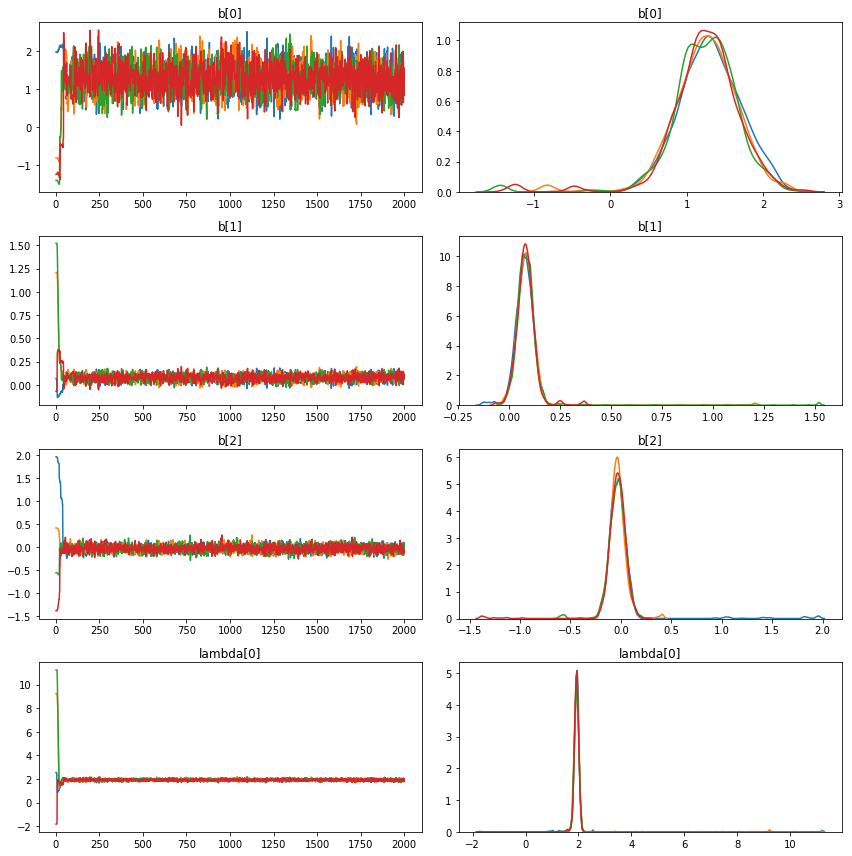

In [212]:
def mcmc_plot(fit, n_params):
    palette = sns.color_palette()
    ms = fit.extract(permuted=False, inc_warmup=True)
    iter_from = fit.sim['warmup']
    iter_range = np.arange(0, ms.shape[0])
    paraname = fit.sim['fnames_oi']

    plt.figure(figsize=(12, 12))
    for pos in range(n_params):
        pi = pos
        if pi >= len(paraname): break
        plt.subplot(n_params, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.subplot(n_params, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])

mcmc_plot(fit, 4)

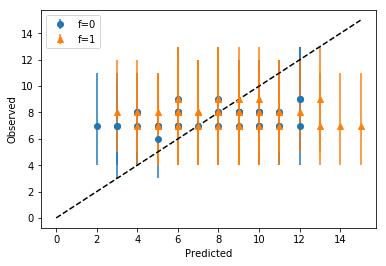

In [213]:
y_pred = fit.extract()['y_pred'].T
f = df['f'].values

y_pred_err_u = np.median(y_pred, axis=1) - np.percentile(y_pred, 10.0, axis=1)
y_pred_err_d = np.percentile(y_pred, 90.0, axis=1) - np.median(y_pred, axis=1)
y_pred_err = np.vstack([y_pred_err_u, y_pred_err_d])

plt.errorbar(df[df['f'] == 0]['y'], np.median(y_pred[f == 0], axis=1), yerr=y_pred_err[:, f == 0], fmt="o", label="f=0")
plt.errorbar(df[df['f'] == 1]['y'], np.median(y_pred[f == 1], axis=1), yerr=y_pred_err[:, f == 1], fmt='^', label="f=1")
plt.plot([0, 15], [0, 15], "k--")
# plt.xlim(0.0, 0.5)
# plt.ylim(0.0, 0.5)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.legend()

,N,y,x,f
0,8,1,9.76,C
1,8,6,10.48,C
2,8,5,10.83,C
3,8,6,10.94,C
4,8,1,9.37,C


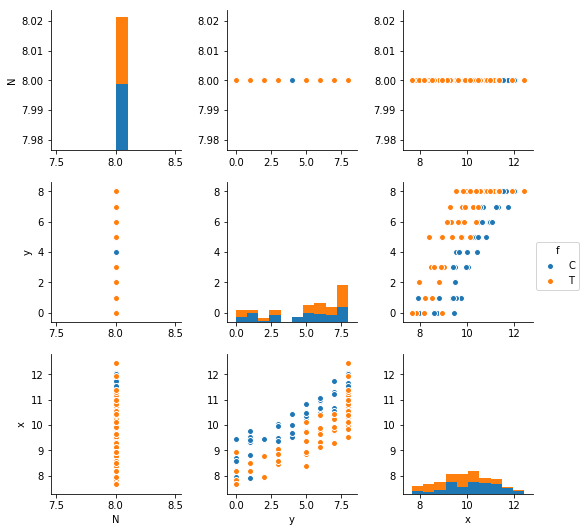

In [200]:
df = pd.read_csv('./input/data4a.csv')
display(df.head())
sns.pairplot(df, hue='f')

In [201]:
f_map = dict(C=0, T=1)
df['f'] = df['f'].apply(lambda x: f_map[x])
df.head()

,N,y,x,f
0,8,1,9.76,0
1,8,6,10.48,0
2,8,5,10.83,0
3,8,6,10.94,0
4,8,1,9.37,0


In [202]:
model = pystan.StanModel('./exercise/ex7.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8934a12bd37b393a2b1dc1dfdbfa77c4 NOW.


In [203]:
stan_data = {
    'F': df['f'].values,
    'X': df['x'].values,
    'Y': df['y'].values,
    'N': df['N'],
    'I': df.shape[0],
}
fit = model.sampling(data=stan_data, seed=1234)
display(fit)

Inference for Stan model: anon_model_8934a12bd37b393a2b1dc1dfdbfa77c4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]       -19.65    0.05   1.42 -22.43 -20.59 -19.65 -18.63 -16.96    955    1.0
b[1]         1.96  4.5e-3   0.14    1.7   1.86   1.96   2.06   2.24    975    1.0
b[2]         2.04  6.7e-3   0.23    1.6   1.88   2.04    2.2   2.49   1187    1.0
q[0]         0.38  7.7e-4   0.03   0.32   0.36   0.38    0.4   0.45   1794    1.0
q[1]         0.72  5.6e-4   0.03   0.66    0.7   0.72   0.73   0.77   2557    1.0
q[2]         0.83  5.0e-4   0.02   0.79   0.82   0.83   0.85   0.87   2039    1.0
q[3]         0.86  4.7e-4   0.02   0.82   0.85   0.86   0.87    0.9   1905    1.0
q[4]         0.22  8.2e-4   0.03   0.17    0.2   0.22   0.24   0.28   1266    1.0
q[5]         0.09  5.7e-4   0.02   0.06   0.08   0.09    0.1   0.13   103

/Users/tomohiro/Workspace/RStanBook-Python/.env/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  This is separate from the ipykernel package so we can avoid doing imports until


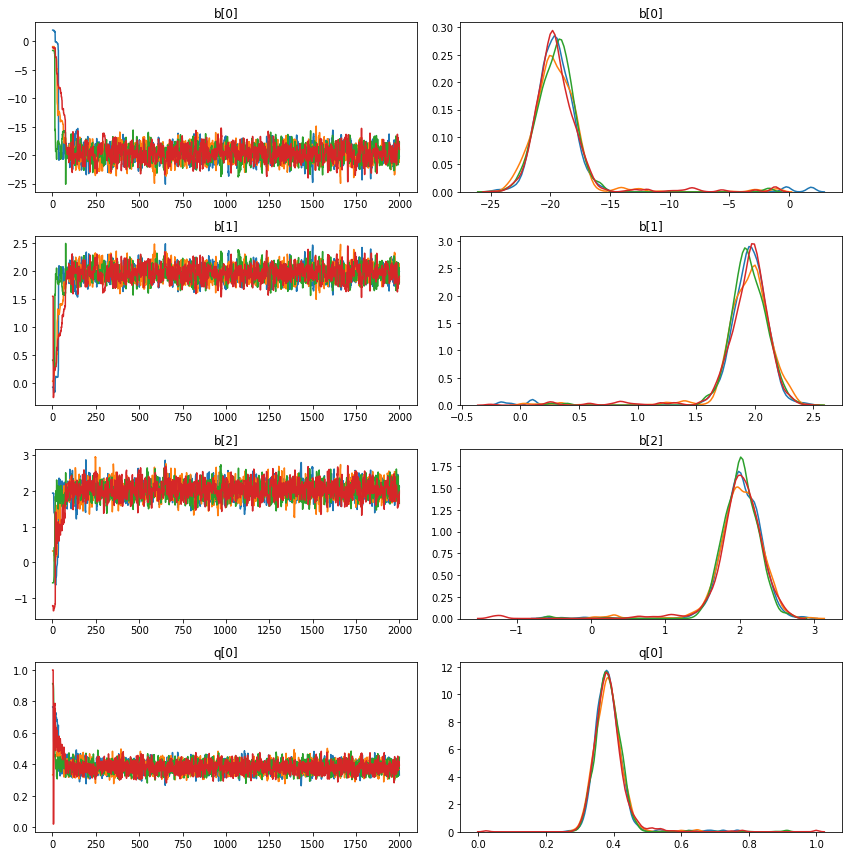

In [204]:
def mcmc_plot(fit, n_params):
    palette = sns.color_palette()
    ms = fit.extract(permuted=False, inc_warmup=True)
    iter_from = fit.sim['warmup']
    iter_range = np.arange(0, ms.shape[0])
    paraname = fit.sim['fnames_oi']

    plt.figure(figsize=(12, 12))
    for pos in range(n_params):
        pi = pos
        if pi >= len(paraname): break
        plt.subplot(n_params, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.subplot(n_params, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])

mcmc_plot(fit, 4)

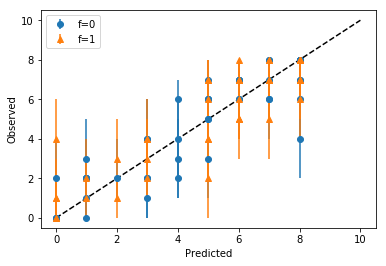

In [206]:
y_pred = fit.extract()['y_pred'].T
f = df['f'].values

y_pred_err_u = np.median(y_pred, axis=1) - np.percentile(y_pred, 10.0, axis=1)
y_pred_err_d = np.percentile(y_pred, 90.0, axis=1) - np.median(y_pred, axis=1)
y_pred_err = np.vstack([y_pred_err_u, y_pred_err_d])

plt.errorbar(df[df['f'] == 0]['y'], np.median(y_pred[f == 0], axis=1), yerr=y_pred_err[:, f == 0], fmt="o", label="f=0")
plt.errorbar(df[df['f'] == 1]['y'], np.median(y_pred[f == 1], axis=1), yerr=y_pred_err[:, f == 1], fmt='^', label="f=1")
plt.plot([0, 10], [0, 10], "k--")
# plt.xlim(0.0, 0.5)
# plt.ylim(0.0, 0.5)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.legend()